# Medical NLP Pipeline - Physician Notetaker

This notebook implements a comprehensive NLP system for:
1. **Medical Entity Recognition (NER)** - Extract symptoms, treatments, diagnosis, and prognosis
2. **Text Summarization** - Generate structured medical reports
3. **Keyword Extraction** - Identify important medical phrases
4. **Sentiment Analysis** - Detect patient emotional state
5. **Intent Detection** - Classify patient communication intent
6. **SOAP Note Generation** - Create structured clinical notes

## Setup and Installation

In [43]:
# Install required packages
!pip install spacy transformers torch sentence-transformers scikit-learn nltk pandas matplotlib seaborn -q
!python -m spacy download en_core_web_sm -q


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import json
import re
from typing import Dict, List, Tuple
import warnings
warnings.filterwarnings('ignore')

import spacy
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from collections import defaultdict
import nltk
from nltk.tokenize import sent_tokenize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download NLTK data
nltk.download('punkt', quiet=True)

print("All libraries imported successfully.")

All libraries imported successfully.


## Sample Medical Transcript

In [45]:
transcript = """
Physician: Good morning, Ms. Jones. How are you feeling today?

Patient: Good morning, doctor. I'm doing better, but I still have some discomfort now and then.

Physician: I understand you were in a car accident last September. Can you walk me through what happened?

Patient: Yes, it was on September 1st, around 12:30 in the afternoon. I was driving from Cheadle Hulme to Manchester when I had to stop in traffic. Out of nowhere, another car hit me from behind, which pushed my car into the one in front.

Physician: That sounds like a strong impact. Were you wearing your seatbelt?

Patient: Yes, I always do.

Physician: What did you feel immediately after the accident?

Patient: At first, I was just shocked. But then I realized I had hit my head on the steering wheel, and I could feel pain in my neck and back almost right away.

Physician: Did you seek medical attention at that time?

Patient: Yes, I went to Moss Bank Accident and Emergency. They checked me over and said it was a whiplash injury, but they didn't do any X-rays. They just gave me some advice and sent me home.

Physician: How did things progress after that?

Patient: The first four weeks were rough. My neck and back pain were really bad—I had trouble sleeping and had to take painkillers regularly. It started improving after that, but I had to go through ten sessions of physiotherapy to help with the stiffness and discomfort.

Physician: That makes sense. Are you still experiencing pain now?

Patient: It's not constant, but I do get occasional backaches. It's nothing like before, though.

Physician: That's good to hear. Have you noticed any other effects, like anxiety while driving or difficulty concentrating?

Patient: No, nothing like that. I don't feel nervous driving, and I haven't had any emotional issues from the accident.

Physician: And how has this impacted your daily life? Work, hobbies, anything like that?

Patient: I had to take a week off work, but after that, I was back to my usual routine. It hasn't really stopped me from doing anything.

Physician: That's encouraging. Let's go ahead and do a physical examination to check your mobility and any lingering pain.

[Physical Examination Conducted]

Physician: Everything looks good. Your neck and back have a full range of movement, and there's no tenderness or signs of lasting damage. Your muscles and spine seem to be in good condition.

Patient: That's a relief!

Physician: Yes, your recovery so far has been quite positive. Given your progress, I'd expect you to make a full recovery within six months of the accident. There are no signs of long-term damage or degeneration.

Patient: That's great to hear. So, I don't need to worry about this affecting me in the future?

Physician: That's right. I don't foresee any long-term impact on your work or daily life. If anything changes or you experience worsening symptoms, you can always come back for a follow-up. But at this point, you're on track for a full recovery.

Patient: Thank you, doctor. I appreciate it.

Physician: You're very welcome, Ms. Jones. Take care, and don't hesitate to reach out if you need anything.
"""

print("Transcript loaded. Length:", len(transcript.split()), "words")

Transcript loaded. Length: 531 words


## 1. Named Entity Recognition (NER)

Extract medical entities: Symptoms, Treatment, Diagnosis, Prognosis

In [46]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

def extract_medical_entities(transcript: str) -> Dict[str, List[str]]:
    """Extract medical entities using rule-based NER"""
    doc = nlp(transcript)
    
    entities = {
        "Symptoms": [],
        "Treatment": [],
        "Diagnosis": [],
        "Prognosis": [],
        "Dates": [],
        "Locations": []
    }
    
    # Define medical keywords
    symptom_keywords = ["pain", "hurt", "ache", "discomfort", "soreness", "stiffness", 
                        "swelling", "tenderness", "numbness", "anxiety"]
    treatment_keywords = ["therapy", "physiotherapy", "treatment", "painkiller", 
                          "analgesic", "session", "x-ray", "examination"]
    diagnosis_keywords = ["injury", "whiplash", "fracture", "sprain", "strain", "trauma"]
    prognosis_keywords = ["recovery", "prognosis", "improve", "heal", "better", "full recovery"]
    
    sentences = sent_tokenize(transcript)
    
    for sentence in sentences:
        sentence_lower = sentence.lower()
        sent_doc = nlp(sentence)
        
        # Extract entities by category
        for keyword in symptom_keywords:
            if keyword in sentence_lower:
                for chunk in sent_doc.noun_chunks:
                    if keyword in chunk.text.lower():
                        symptom = chunk.text.strip()
                        if symptom and symptom not in entities["Symptoms"]:
                            entities["Symptoms"].append(symptom)
        
        for keyword in treatment_keywords:
            if keyword in sentence_lower:
                for chunk in sent_doc.noun_chunks:
                    if keyword in chunk.text.lower():
                        treatment = chunk.text.strip()
                        if treatment and treatment not in entities["Treatment"]:
                            entities["Treatment"].append(treatment)
        
        for keyword in diagnosis_keywords:
            if keyword in sentence_lower:
                for chunk in sent_doc.noun_chunks:
                    if keyword in chunk.text.lower():
                        diagnosis = chunk.text.strip()
                        if diagnosis and diagnosis not in entities["Diagnosis"]:
                            entities["Diagnosis"].append(diagnosis)
        
        for keyword in prognosis_keywords:
            if keyword in sentence_lower:
                prognosis = sentence.strip()
                if prognosis not in entities["Prognosis"]:
                    entities["Prognosis"].append(prognosis)
        
        # Extract dates and locations
        for ent in sent_doc.ents:
            if ent.label_ == "DATE" and ent.text not in entities["Dates"]:
                entities["Dates"].append(ent.text)
            elif ent.label_ in ["GPE", "LOC"] and ent.text not in entities["Locations"]:
                entities["Locations"].append(ent.text)
    
    return entities

# Extract entities
entities = extract_medical_entities(transcript)
print("\nMEDICAL ENTITIES EXTRACTED:\n")
print(json.dumps(entities, indent=2))


MEDICAL ENTITIES EXTRACTED:

{
  "Symptoms": [
    "some discomfort",
    "pain",
    "back pain",
    "painkillers",
    "the stiffness",
    "occasional backaches",
    "anxiety",
    "any lingering pain",
    "no tenderness"
  ],
  "Treatment": [
    "painkillers",
    "physiotherapy",
    "ten sessions",
    "a physical examination"
  ],
  "Diagnosis": [
    "a whiplash injury"
  ],
  "Prognosis": [
    "I'm doing better, but I still have some discomfort now and then.",
    "Physician: Yes, your recovery so far has been quite positive.",
    "Given your progress, I'd expect you to make a full recovery within six months of the accident.",
    "But at this point, you're on track for a full recovery."
  ],
  "Dates": [
    "today",
    "last September",
    "September 1st",
    "The first four weeks",
    "daily",
    "a week",
    "six months"
  ],
  "Locations": []
}


## 2. Keyword Extraction

In [47]:
def extract_keywords(transcript: str, top_n: int = 10) -> List[str]:
    """Extract important medical keywords"""
    doc = nlp(transcript)
    
    medical_terms = []
    for chunk in doc.noun_chunks:
        if len(chunk.text.split()) >= 2:
            medical_terms.append(chunk.text.lower())
    
    # Count frequency
    keyword_freq = defaultdict(int)
    for term in medical_terms:
        keyword_freq[term] += 1
    
    # Sort and return top N
    sorted_keywords = sorted(keyword_freq.items(), key=lambda x: x[1], reverse=True)
    return [kw[0] for kw in sorted_keywords[:top_n]]

keywords = extract_keywords(transcript)
print("\nIMPORTANT MEDICAL KEYWORDS:\n")
for i, keyword in enumerate(keywords, 1):
    print(f"{i}. {keyword}")


IMPORTANT MEDICAL KEYWORDS:

1. the accident
2. my neck
3. a full recovery
4. good morning
5. ms. jones
6. some discomfort
7. a car accident
8. september 1st
9. the afternoon
10. cheadle hulme


## 3. Text Summarization - Structured Medical Report

In [48]:
def generate_summary(transcript: str, entities: Dict) -> Dict:
    """Generate structured medical summary"""
    
    # Extract patient name
    match = re.search(r"Ms\.\s+([A-Z][a-z]+)", transcript)
    patient_name = match.group(1) if match else "Unknown"
    
    # Extract current status
    current_status = "Improving"
    sentences = sent_tokenize(transcript)
    for sentence in sentences:
        if "occasional" in sentence.lower() and "pain" in sentence.lower():
            current_status = sentence.strip()
            break
    
    # Extract prognosis
    prognosis = "Good"
    for prog in entities["Prognosis"]:
        if "full recovery" in prog.lower():
            prognosis = prog
            break
    
    summary = {
        "Patient_Name": patient_name,
        "Symptoms": entities["Symptoms"][:5] if entities["Symptoms"] else ["Not specified"],
        "Diagnosis": entities["Diagnosis"][0] if entities["Diagnosis"] else "Not specified",
        "Treatment": entities["Treatment"][:3] if entities["Treatment"] else ["Not specified"],
        "Current_Status": current_status,
        "Prognosis": prognosis
    }
    
    return summary

summary = generate_summary(transcript, entities)
print("\nSTRUCTURED MEDICAL SUMMARY:\n")
print(json.dumps(summary, indent=2))


STRUCTURED MEDICAL SUMMARY:

{
  "Patient_Name": "Jones",
  "Symptoms": [
    "some discomfort",
    "pain",
    "back pain",
    "painkillers",
    "the stiffness"
  ],
  "Diagnosis": "a whiplash injury",
  "Treatment": [
    "painkillers",
    "physiotherapy",
    "ten sessions"
  ],
  "Current_Status": "Improving",
  "Prognosis": "Given your progress, I'd expect you to make a full recovery within six months of the accident."
}


**Questions:**

- How would you handle **ambiguous or missing medical data** in the transcript?

    Answer:
    
    • Assign structured placeholders like unknown or not mentioned and use confidence scores to avoid assumptions.
    
    • Track exact evidence text and apply negation and uncertainty detection so unclear statements stay flagged.
    
    • Use ontology mapping such as UMLS or SNOMED with top-k candidates and route low-confidence cases to human review.



- What **pre-trained NLP models** would you use for medical summarization?

    Answer:

    • ClinicalBERT or PubMedBERT for medical concept understanding and entity extraction.
    
    • LED, PEGASUS or BART adapted for long clinical text summarization.
    
    • Train further on clinical note datasets such as MIMIC and dialogue data like MedDialog.

## 4. Sentiment Analysis

Analyze patient emotional state using transformer models

In [49]:
# Load sentiment analysis model
print("Loading sentiment analysis model...")
sentiment_analyzer = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english"
)
print("Model loaded")

def analyze_sentiment(text: str) -> Dict:
    """Analyze sentiment of patient dialogue"""
    result = sentiment_analyzer(text[:512])[0]
    
    label = result['label']
    score = result['score']
    
    # Map to medical context
    if label == "NEGATIVE" and score > 0.7:
        sentiment = "Anxious"
    elif label == "POSITIVE" and score > 0.7:
        sentiment = "Reassured"
    else:
        sentiment = "Neutral"
    
    return {
        "Sentiment": sentiment,
        "Confidence": round(score, 3)
    }

# Test with sample patient dialogues
patient_dialogues = [
    "I'm doing better, but I still have some discomfort now and then.",
    "The first four weeks were rough. My neck and back pain were really bad.",
    "I'm a bit worried about my back pain, but I hope it gets better soon.",
    "That's great to hear. So, I don't need to worry about this affecting me in the future?"
]

print("\nSENTIMENT ANALYSIS:\n")
sentiment_results = []
for dialogue in patient_dialogues:
    result = analyze_sentiment(dialogue)
    sentiment_results.append(result)
    print(f"Text: \"{dialogue[:60]}...\"")
    print(f"Sentiment: {result['Sentiment']} (Confidence: {result['Confidence']})\n")

Loading sentiment analysis model...


Device set to use cpu


Model loaded

SENTIMENT ANALYSIS:

Text: "I'm doing better, but I still have some discomfort now and t..."
Sentiment: Anxious (Confidence: 0.996)

Text: "The first four weeks were rough. My neck and back pain were ..."
Sentiment: Anxious (Confidence: 1.0)

Text: "I'm a bit worried about my back pain, but I hope it gets bet..."
Sentiment: Reassured (Confidence: 0.973)

Text: "That's great to hear. So, I don't need to worry about this a..."
Sentiment: Reassured (Confidence: 1.0)



## 5. Intent Detection

Classify patient communication intent using zero-shot classification

In [50]:
# Load intent classification model
print("Loading intent detection model...")
intent_classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)
print("Model loaded")

def detect_intent(text: str) -> Dict:
    """Detect patient intent"""
    candidate_labels = [
        "Seeking reassurance",
        "Reporting symptoms",
        "Expressing concern",
        "Asking questions",
        "Providing information"
    ]
    
    result = intent_classifier(text[:512], candidate_labels, multi_label=False)
    
    return {
        "Intent": result['labels'][0],
        "Confidence": round(result['scores'][0], 3)
    }

print("\nINTENT DETECTION:\n")
for dialogue in patient_dialogues:
    result = detect_intent(dialogue)
    print(f"Text: \"{dialogue[:60]}...\"")
    print(f"Intent: {result['Intent']} (Confidence: {result['Confidence']})\n")

Loading intent detection model...


Device set to use cpu


Model loaded

INTENT DETECTION:

Text: "I'm doing better, but I still have some discomfort now and t..."
Intent: Reporting symptoms (Confidence: 0.497)

Text: "The first four weeks were rough. My neck and back pain were ..."
Intent: Reporting symptoms (Confidence: 0.45)

Text: "I'm a bit worried about my back pain, but I hope it gets bet..."
Intent: Expressing concern (Confidence: 0.647)

Text: "That's great to hear. So, I don't need to worry about this a..."
Intent: Seeking reassurance (Confidence: 0.454)



**Questions:**

- How would you fine-tune **BERT** for medical sentiment detection?
  
    Answer:
    
    • Start from a clinical domain BERT and add a three-class classifier for anxious, neutral, reassured.
    
    • Integrate negation and uncertainty handling to separate worry from denial.
    
    • Handle class imbalance with weighted loss and calibrate model outputs.


- What datasets would you use for training a **healthcare-specific** sentiment model?

    Answer: 
    
    • MedDialog for patient-doctor conversation sentiment and intent.
    
    • SMM4H health related sentiment corpora for extra training.
    
    • Build a small labeled set from real transcripts and add weak supervision.

## 6. SOAP Note Generation

Generate structured clinical notes (Subjective, Objective, Assessment, Plan)

In [51]:
def generate_soap_note(transcript: str, entities: Dict) -> Dict:
    """Generate SOAP note from transcript"""
    sentences = sent_tokenize(transcript)
    
    # SUBJECTIVE
    chief_complaint = entities["Symptoms"][0] if entities["Symptoms"] else "Not specified"
    
    history_sentences = []
    for sent in sentences:
        if any(word in sent.lower() for word in ["accident", "weeks", "September"]):
            history_sentences.append(sent)
    history = " ".join(history_sentences[:3]) if history_sentences else "Not specified"
    
    # OBJECTIVE
    physical_exam = "Not documented"
    for sent in sentences:
        if "range of motion" in sent.lower() or "examination" in sent.lower():
            physical_exam = sent
            break
    
    # ASSESSMENT
    diagnosis = entities["Diagnosis"][0] if entities["Diagnosis"] else "Not specified"
    severity = "Mild, improving"
    
    # PLAN
    treatment = ", ".join(entities["Treatment"][:3]) if entities["Treatment"] else "Not specified"
    follow_up = "Follow-up as needed"
    for sent in sentences:
        if "follow-up" in sent.lower() or "six months" in sent.lower():
            follow_up = sent
            break
    
    soap_note = {
        "Subjective": {
            "Chief_Complaint": chief_complaint,
            "History_of_Present_Illness": history
        },
        "Objective": {
            "Physical_Exam": physical_exam,
            "Observations": "Patient appears in normal health"
        },
        "Assessment": {
            "Diagnosis": diagnosis,
            "Severity": severity
        },
        "Plan": {
            "Treatment": treatment,
            "Follow_Up": follow_up
        }
    }
    
    return soap_note

soap_note = generate_soap_note(transcript, entities)
print("\nSOAP NOTE:\n")
print(json.dumps(soap_note, indent=2))


SOAP NOTE:

{
  "Subjective": {
    "Chief_Complaint": "some discomfort",
    "History_of_Present_Illness": "Physician: I understand you were in a car accident last September. Physician: What did you feel immediately after the accident? Patient: Yes, I went to Moss Bank Accident and Emergency."
  },
  "Objective": {
    "Physical_Exam": "Let's go ahead and do a physical examination to check your mobility and any lingering pain.",
    "Observations": "Patient appears in normal health"
  },
  "Assessment": {
    "Diagnosis": "a whiplash injury",
    "Severity": "Mild, improving"
  },
  "Plan": {
    "Treatment": "painkillers, physiotherapy, ten sessions",
    "Follow_Up": "Given your progress, I'd expect you to make a full recovery within six months of the accident."
  }
}


**Questions:**

- How would you train an NLP model to **map medical transcripts into SOAP format**?

    Answer:

    • Use two stages: extract clinical facts then feed to a sequence model to generate SOAP sections.
    
    • Constrain output format and favor direct text copying to avoid incorrect content.
    
    • Train on transcript to SOAP pairs and refine with curated examples.


  



- What **rule-based or deep-learning** techniques would improve the accuracy of SOAP note generation?

    Answer:
    
    • Rule routing: patient speech→Subjective, exam lines→Objective, diagnosis/prognosis→Assessment, plan→Plan.
    
    • JSON schema checks plus span-copy to ensure factual, structured outputs.
    
    • Use long context models and consistency checks on symptoms, timeline, and plans.


## 7. Visualization

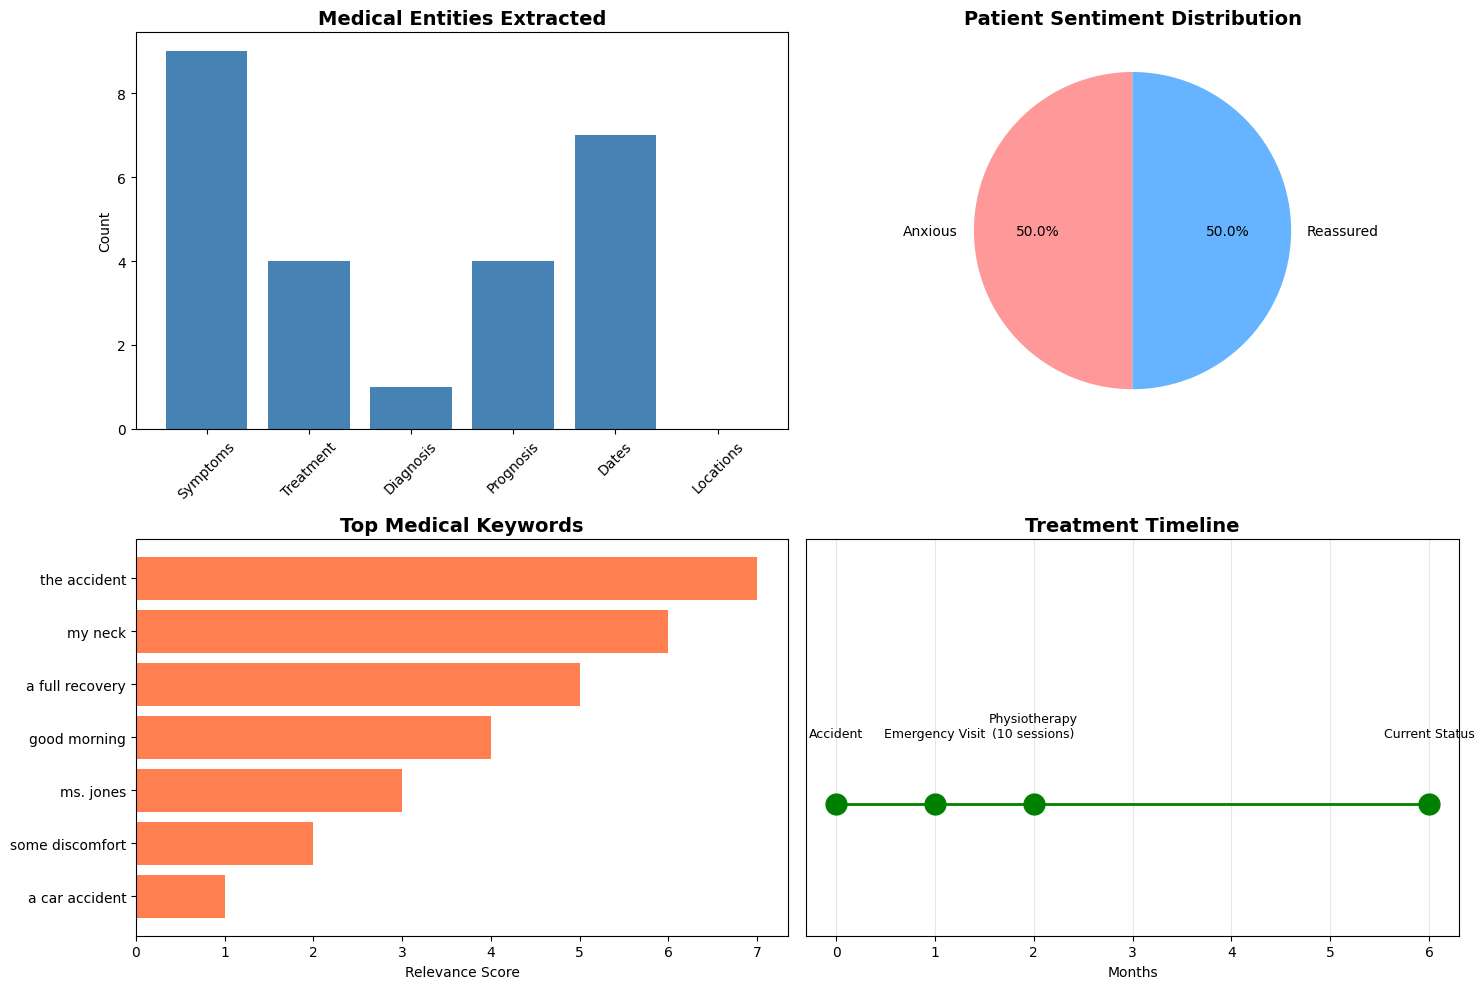


Visualization saved


In [52]:
# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Entity Distribution
entity_counts = {k: len(v) for k, v in entities.items()}
axes[0, 0].bar(entity_counts.keys(), entity_counts.values(), color='steelblue')
axes[0, 0].set_title('Medical Entities Extracted', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Sentiment Distribution
sentiment_counts = defaultdict(int)
for result in sentiment_results:
    sentiment_counts[result['Sentiment']] += 1
axes[0, 1].pie(sentiment_counts.values(), labels=sentiment_counts.keys(), 
               autopct='%1.1f%%', startangle=90, colors=['#ff9999', '#66b3ff', '#99ff99'])
axes[0, 1].set_title('Patient Sentiment Distribution', fontsize=14, fontweight='bold')

# 3. Top Keywords
axes[1, 0].barh(keywords[:7], range(7, 0, -1), color='coral')
axes[1, 0].set_title('Top Medical Keywords', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Relevance Score')
axes[1, 0].invert_yaxis()

# 4. Treatment Timeline 
timeline_data = ['Accident', 'Emergency Visit', 'Physiotherapy\n(10 sessions)', 'Current Status']
timeline_dates = [0, 1, 2, 6]
axes[1, 1].plot(timeline_dates, [1]*4, 'o-', markersize=15, linewidth=2, color='green')
for i, (date, event) in enumerate(zip(timeline_dates, timeline_data)):
    axes[1, 1].text(date, 1.05, event, ha='center', fontsize=9)
axes[1, 1].set_title('Treatment Timeline', fontsize=14, fontweight='bold')
axes[1, 1].set_ylim(0.9, 1.2)
axes[1, 1].set_xlabel('Months')
axes[1, 1].set_yticks([])
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('C:/Users/mahia/OneDrive/Documents/medical_nlp_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved")

## 8. Save All Results

In [53]:
# Compile all results
complete_results = {
    "patient_name": summary["Patient_Name"],
    "medical_entities": entities,
    "keywords": keywords,
    "structured_summary": summary,
    "sentiment_analysis": [
        {"text": dialogue, **analyze_sentiment(dialogue)} 
        for dialogue in patient_dialogues
    ],
    "intent_detection": [
        {"text": dialogue, **detect_intent(dialogue)} 
        for dialogue in patient_dialogues
    ],
    "soap_note": soap_note
}

# Save to JSON
with open('C:/Users/mahia/OneDrive/Documents/complete_medical_analysis.json', 'w') as f:
    json.dump(complete_results, f, indent=2)

print("\nAll results saved to: complete_medical_analysis.json")
print("Analysis Complete")


All results saved to: complete_medical_analysis.json
Analysis Complete
